In [1]:

"""
2D Poisson Equation
    Spatial: Iterative solvers (FFT/FST)
"""
import sys
import numpy as np
import scipy
from numba import njit,jit,float64,int64

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import scipy.sparse
import numpy.linalg
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [2]:
@njit(float64(float64[:,:]))
def rms(a):
    return np.sqrt(np.mean(a**2))


In [3]:
@njit
def residualPoisson(fA, dX, dY, u):
    r = fA*0
    r[1:-1,1:-1] = fA[1:-1,1:-1] - (u[2:,1:-1]+u[0:-2,1:-1]-2*u[1:-1,1:-1])/dX**2 - (u[1:-1,2:]+u[1:-1,0:-2]-2*u[1:-1,1:-1])/dY**2
    return r

In [4]:
@njit
def GaussSeidelPoisson(fA, dX, dY, mA, nA, Nx, Ny, uIni,tol,maxIter,display):

    d = -2/dX**2 -2/dY**2
    u = uIni*1
    r = fA*0
    relError = tol+1
    for numIter in range(maxIter):
        if (numIter%50==0):
            if display:
                print(numIter, relError)
        for i in np.arange(1,Nx-1):
            for j in np.arange(1,Ny-1):
                r[i,j] = fA[i,j] - (u[i+1,j]+u[i-1,j] - 2*u[i,j])/dX**2 - (u[i,j+1]+u[i,j-1] - 2*u[i,j])/dY**2
                u[i,j] = u[i,j]+r[i,j]/d
        relError = rms(r)
        if relError<tol:
            break
    #print("The solution stops at error = {relError:.3e}, steps = {iter:5d}")
    if display:
        print(numIter, relError)
    return u


In [5]:
@njit
def ConjugateGradientPoisson(fA, dX, dY, mA, nA, Nx, Ny, uIni,tol,maxIter):
    eps = 1e-16
    d = -2/dX**2 -2/dY**2

    u = uIni*1
    r = residualPoisson(fA, dX, dY, u)
    p = r*1 # setting the boundary condition of p will let residual blow up
    q = r*0
    relError = tol+1
    for numIter in range(maxIter):
        if (numIter%50==0):
            print(numIter, relError)

        # q = Ap
        q[1:Nx-1,1:Ny-1] = (p[2:Nx,1:Ny-1]+p[0:Nx-2,1:Ny-1]-2*p[1:Nx-1,1:Ny-1])/dX**2 + (p[1:Nx-1,2:Ny]+p[1:Nx-1,0:Ny-2]-2*p[1:Nx-1,1:Ny-1])/dY**2

        # <r,r> <q,p>
        rho = np.sum(r[1:Nx-1,1:Ny-1]**2)
        pq = np.sum(q[1:Nx-1,1:Ny-1]*p[1:Nx-1,1:Ny-1])
        alpha = rho/(pq+eps)

        u[1:Nx-1,1:Ny-1] = u[1:Nx-1,1:Ny-1]+alpha*p[1:Nx-1,1:Ny-1]

        pq = rho
        r[1:Nx-1,1:Ny-1] = r[1:Nx-1,1:Ny-1]-alpha*q[1:Nx-1,1:Ny-1]
        rho = np.sum(r[1:Nx-1,1:Ny-1]**2)
        beta = rho/(pq+eps)

        p[1:Nx-1,1:Ny-1] = r[1:Nx-1,1:Ny-1] + beta*p[1:Nx-1,1:Ny-1]

        # r = b - Ax
        r = residualPoisson(fA, dX, dY, u)

        relError = rms(r)

        if relError<tol:
            break

        if numIter >= (Nx-1)*(Ny-1):
            break
    #print("The solution stops at error = {relError:.3e}, steps = {iter:5d}")
    print(numIter, relError)
    return u



In [6]:
@njit
def restriction(r):
    rCoarse = r[0::2,0::2]
    rCoarse[1:-1,1:-1] = (
        4*r[2:-2:2,2:-2:2] + 
        2*(
            r[1:-3:2,2:-2:2]+r[3:-1:2,2:-2:2]+r[2:-2:2,1:-3:2]+r[2:-2:2,3:-1:2]
        ) + 
        r[0:-4:2,2:-2:2]+r[4::2,2:-2:2]+r[2:-2:2,0:-4:2]+r[2:-2:2,4::2]
    )/16
    return rCoarse

@njit
def prolongation(e):
    nx = e.shape[0]
    ny = e.shape[1]
    efine = np.zeros((2*nx-1, 2*ny-1))

    # v-- --v
    # |  |  |
    #  -- -- 
    # |  |  |
    # v-- --v
    efine[::2,::2] = e

    #  -- -- 
    # |  |  |
    # v-- --v
    # |  |  |
    #  -- -- 
    efine[1:-1:2,::2] = (e[1:,:]+e[:-1,:])/2

    #  --v-- 
    # |  |  |
    #  -- -- 
    # |  |  |
    #  --v-- 
    efine[::2,1:-1:2] = (e[:,1:]+e[:,:-1])/2

    #  -- -- 
    # |  |  |
    #  --v-- 
    # |  |  |
    #  -- -- 
    efine[1:-1:2,1:-1:2] = (e[1:,1:]+e[:-1,:-1]+e[:-1,1:]+e[1:,:-1])/4

    return efine

In [7]:
@jit
def multigridVCycle(fA, dX, dY, mA, nA, Nx, Ny, uIni, tol, maxIter, N):
    eps = 1e-16
    relError = tol+1

    v1,v2,v3 = 2,2,1

    # Number of restriction and prolongation

    geoPrecession = np.arange(0,-N-1,-1)
    Nxl = ((Nx-1)*2.**geoPrecession).astype(int64)+1
    Nyl = ((Ny-1)*2.**geoPrecession).astype(int64)+1

    dXl = dX*2.**-geoPrecession
    dYl = dX*2.**-geoPrecession

    eHandle = [uIni*0]*(N)

    u = uIni*1

    for numIter in range(maxIter):
        if (numIter%50==0):
            print(":::MAIN CYCLE::: ",numIter, relError)

        # Fine grid solve
        u = GaussSeidelPoisson(fA, dXl[0], dYl[0], mA, nA, Nxl[0], Nyl[0], u,tol,v1,False)
        r = residualPoisson(fA, dXl[0], dYl[0], u)

        for iRestriction in range(N):
            r = restriction(r)
            if iRestriction<N-1:
                eHandle[iRestriction] = GaussSeidelPoisson(r, dXl[iRestriction+1], dYl[iRestriction+1], mA, nA, Nxl[iRestriction+1], Nyl[iRestriction+1], r*0,tol,v1,False)
            else:
                eHandle[iRestriction] = GaussSeidelPoisson(r, dXl[iRestriction+1], dYl[iRestriction+1], mA, nA, Nxl[iRestriction+1], Nyl[iRestriction+1], r*0,tol,v2,False)
            r = residualPoisson(r, dXl[iRestriction+1], dYl[iRestriction+1], eHandle[iRestriction])

        for iProlongation in range(N-1,0,-1):
            eHandle[iProlongation-1] = prolongation(eHandle[iProlongation])
            
        u += prolongation(eHandle[0])

        u = GaussSeidelPoisson(fA, dXl[0], dYl[0], mA, nA, Nxl[0], Nyl[0], u,tol,v3,False)
        r = residualPoisson(fA, dXl[0], dYl[0], u)

        relError = rms(r)

        if relError<tol:
            break


    return 0

In [8]:
def ExactSolution(x,y):
    return (x**2-1)*(y**2-1)

def SourceTerm(x,y):
    return -2*(2-x**2-y**2)

In [9]:
xMin, xMax = 0.0, 1.0
yMin, yMax = 0.0, 1.0

tol=1e-9
maxIter=100000

numXCen = 512
numYCen = 512
numXGrid = numXCen+1
numYGrid = numYCen+1

xMat, yMat = np.meshgrid(np.linspace(xMin, xMax, numXGrid), np.linspace(yMin, yMax, numYGrid), indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXGrid), np.arange(numYGrid), indexing="ij")

uExact = ExactSolution(xMat,yMat)
uBoundary = uExact*1
uBoundary[1:-1,1:-1] = 0

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

deltaX = xMat[1,0] - xMat[0,0]
deltaY = yMat[0,1] - yMat[0,0]

rhsF = SourceTerm(xMat, yMat)
# u = GaussSeidelPoisson(rhsF, deltaX, deltaY, mMat, nMat, numXGrid, numYGrid, uBoundary, tol, maxIter,True)
u = multigridVCycle(rhsF, deltaX, deltaY, mMat, nMat, numXGrid, numYGrid, uBoundary, tol, maxIter, N=5)
# u = PoissonFFTCentralDiff(rhsF, deltaX, deltaY, mMat, nMat, numXCen, numYCen)
# u[numXGrid,:] = u[0,:]
# u[:,numYGrid] = u[:,0]



:::MAIN CYCLE:::  0 1.000000001
:::MAIN CYCLE:::  50 150.22239040184593
:::MAIN CYCLE:::  100 89.21660285834975
:::MAIN CYCLE:::  150 61.83130901327517
:::MAIN CYCLE:::  200 45.26842422320164
:::MAIN CYCLE:::  250 34.18521757642374
:::MAIN CYCLE:::  300 26.349170821400723
:::MAIN CYCLE:::  350 20.60613664726639
:::MAIN CYCLE:::  400 16.288970451875294
:::MAIN CYCLE:::  450 12.98246151411402
:::MAIN CYCLE:::  500 10.413850833814939
:::MAIN CYCLE:::  550 8.396383140987886
:::MAIN CYCLE:::  600 6.797954802233844
:::MAIN CYCLE:::  650 5.522654536451281
:::MAIN CYCLE:::  700 4.499365492536511
:::MAIN CYCLE:::  750 3.674441855032547
:::MAIN CYCLE:::  800 3.00684175879849
:::MAIN CYCLE:::  850 2.464797631600355
:::MAIN CYCLE:::  900 2.023480777314202
:::MAIN CYCLE:::  950 1.6633276329435545
:::MAIN CYCLE:::  1000 1.3688176663049099
:::MAIN CYCLE:::  1050 1.1275665385414888
:::MAIN CYCLE:::  1100 0.9296437473362701
:::MAIN CYCLE:::  1150 0.7670529428908985
:::MAIN CYCLE:::  1200 0.633331973363

0.5332683560748965


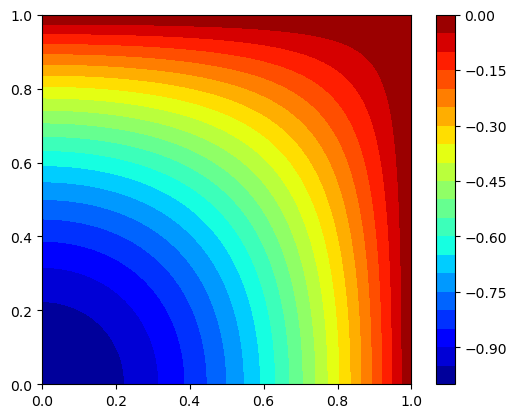

In [ ]:
fig,ax = plt.subplots()
cs = ax.contourf(xMat, yMat, u-uExact, 20, cmap=cm.get_cmap('jet'))
ax.set_xlim((xMin,xMax))
ax.set_ylim((yMin,yMax))
ax.set_aspect("equal")
cbar = fig.colorbar(cs)


print(rms(u-uExact))
